Първото, с което ще започнем, е преработване на размера на снимките. Това е техническо изискване, защото вероятно ще изпозлваме модели на tensotflow. Желаният размер е 400 х 300 (широчина х височина). Реализацията е изключително лесна:

In [ ]:
import os
from PIL import Image

def img_resize(path, width, height):
	
	image = Image.open(path)
		
	image = image.resize((width, height))
	
	image.save(path)
	
	image.close()

def dir_img_resize(dir, width, height):

	files_names_list = os.listdir(dir)

	for file_name in files_names_list:
	
		path = dir + file_name
		
		img_resize(path, width, height)

		print(path) # debug

		
dir_img_resize("../data/clean/", 400, 300)

dir_img_resize("../data/dirty/", 400, 300)

dir_img_resize("../data/borderline/", 400, 300)

В снимките, с които разполагаме, има много цветове, което е неудобно за нас. Нашата задача налага фокус само и единствено върху щайгата в снимката, не ни интересува пространството около щайгата. В идеална среда, снимката ще обхваща само щайгата и нищо друго, но в случая, трябва да намерим начин да я изолираме от останалата час от снимката. Ето как изглежда една снимка:

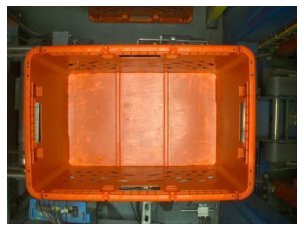

In [9]:
import os
import matplotlib.image
import matplotlib.pyplot

clean_container = matplotlib.image.imread("../data/clean/" + os.listdir("../data/clean/")[0])

matplotlib.pyplot.imshow(clean_container)

matplotlib.pyplot.axis("off")

matplotlib.pyplot.show()

Забелязва се, че изолирането на щайгата може да се реализира чрез анализ на цветовете на пикселите в снимката. Поради удобства, които ще станат очевидни след малко, ще използваме hsv(hue, saturation, value) формат вместо да разглеждаме rgb. 

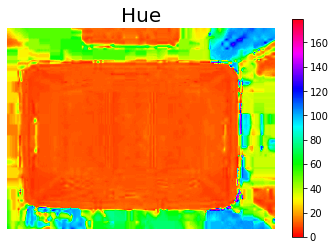

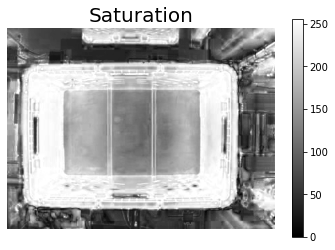

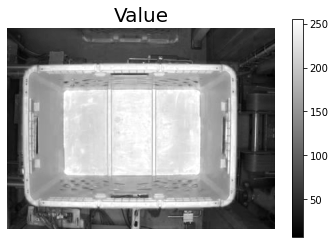

In [13]:
import os
import matplotlib.pyplot
import cv2
import numpy

def image_hsv_plot(image_path):

    clean_container = cv2.imread(image_path)

    clean_container_hsv = cv2.cvtColor(clean_container, cv2.COLOR_BGR2HSV) # BGR is RGB

    # display the channels

    # hue channel

    hue_image = matplotlib.pyplot.imshow(clean_container_hsv[:, :, 0], "hsv") # let's keep adding new syntax

    matplotlib.pyplot.title("Hue", fontsize = 20)

    matplotlib.pyplot.axis("off")

    matplotlib.pyplot.colorbar(hue_image)
    
    matplotlib.pyplot.show()

    # saturation channel

    saturation_image = matplotlib.pyplot.imshow(clean_container_hsv[:, :, 1], "gray")

    matplotlib.pyplot.title("Saturation", fontsize = 20)

    matplotlib.pyplot.axis("off")

    matplotlib.pyplot.colorbar(saturation_image)
    
    matplotlib.pyplot.show()

    # value channel

    value_image = matplotlib.pyplot.imshow(clean_container_hsv[:, :, 2], "gray")

    matplotlib.pyplot.title("Value", fontsize = 20)

    matplotlib.pyplot.axis("off")

    matplotlib.pyplot.colorbar(value_image)
    
    matplotlib.pyplot.show()

image_hsv_plot("../data/clean/" + os.listdir("../data/clean/")[0])

Предимството, което hsv форматът ни предоставя, е възможността да извлечем наситеността на светлината във снимката. Точно над зоната, в която може да има замърсявания, е поставена лампа, и тя свети най - ярко там. Това може да се забележи в снимките горе. Сега освен по цвят, може да изолираме обекти и по това колко са осветени. На база данните, които имаме, можем да съставим маска, чрез която ще направим изолацията и ще изолираме щайгата:

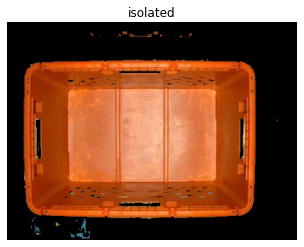

In [3]:
import os
import matplotlib.pyplot
import cv2
import numpy

# returns image
def container_isolate(image_path):

    container = cv2.imread(image_path)

    container_hsv = cv2.cvtColor(container, cv2.COLOR_BGR2HSV)

    hue = (container_hsv[:, :, 0] < 100) * (container_hsv[:, :, 0] > 3)

    saturation = (container_hsv[:, :, 1] > 70)

    value = (container_hsv[:, :, 2] > 120)

    mask = saturation * value * hue

    container_hsv[:, :, 0] *= mask

    container_hsv[:, :, 1] *= mask

    container_hsv[:, :, 2] *= mask

    container = cv2.cvtColor(container_hsv, cv2.COLOR_HSV2RGB)

    return container

dir_name = "../data/clean/"

files_names = os.listdir(dir_name)

container = container_isolate(dir + files_names[0])

matplotlib.pyplot.title("isolated")

matplotlib.pyplot.imshow(container)

matplotlib.pyplot.axis("off")

matplotlib.pyplot.show()

След много опити се установи, че тези стойности най - безопасно изолират контейнера в голямо количество от снимките. 
Вече може да се забележи как задачата ни става все по - проста. Следващата стъпка на опростяване е свеждане на снимката до контури, които после може да анализираме.

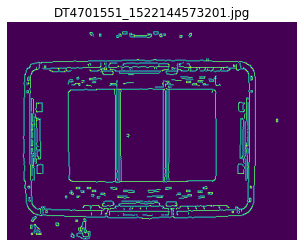

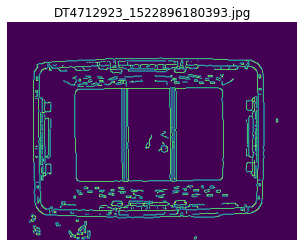

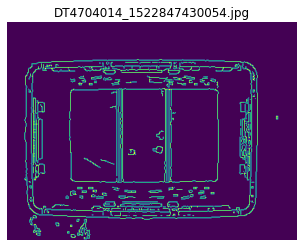

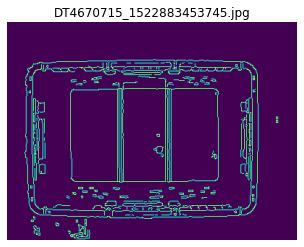

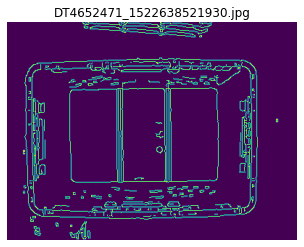

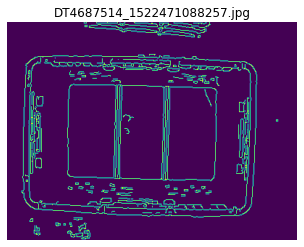

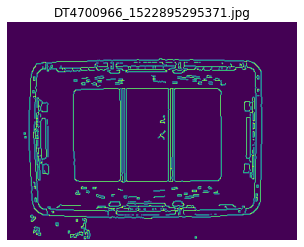

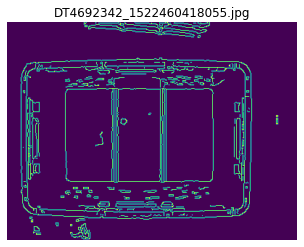

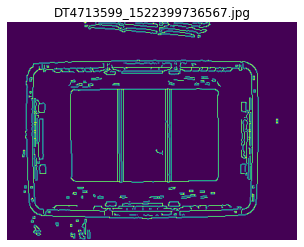

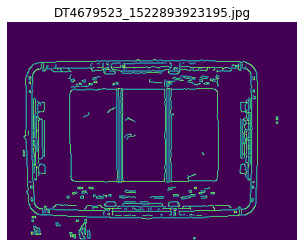

In [4]:
import os
import matplotlib.pyplot
import cv2
import numpy

# returns rgb
def container_isolate(image_path):

    image = cv2.imread(image_path)

    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    hue = (image_hsv[:, :, 0] < 100) * (image_hsv[:, :, 0] > 3)

    saturation = (image_hsv[:, :, 1] > 70)

    value = (image_hsv[:, :, 2] > 120)

    mask = saturation * value * hue

    image_hsv[:, :, 0] *= mask

    image_hsv[:, :, 1] *= mask

    image_hsv[:, :, 2] *= mask

    container = cv2.cvtColor(image_hsv, cv2.COLOR_HSV2RGB)

    return container

def edges_detect(container):

    processed_container = cv2.GaussianBlur(cv2.cvtColor(container, cv2.COLOR_RGB2GRAY), (3, 3), 0)

    # canny edge detection

    median = numpy.median(processed_container)

    lower = int(max(0, 0.66 * median))

    upper = int(min(255, 1.33 * median))

    container_edges = cv2.Canny(image = processed_container, threshold1 = lower, threshold2 = upper)

    return container_edges

dir_name = "../data/clean/"

files_names = os.listdir(dir_name)

files_count = len(files_names)

for i in range(0, 10):

    file_path = dir_name + files_names[i]

    container = container_isolate(file_path)    

    container_edges = edges_detect(container)

    matplotlib.pyplot.title(files_names[i])

    matplotlib.pyplot.imshow(container_edges)

    matplotlib.pyplot.axis("off")

    matplotlib.pyplot.show()

Тук изниква проблем - щайгите, които са изобразени отгоре, нямат замърсявания от външен източник, но с продължителното използване, те започват да се надират. Няма начин да направим сигурно разграничаване на замърсявания и надирания(или обелвания). Това означава, че за да може да продължим да опростяваме проблема, трябва щайгите да бъдат пребоядисани - нещо, което ние не можем да осигурим. Поради тази причина, сме длъжни да се върнем към миналия етап засега.